In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import itertools
import warnings
import numpy as np

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Platinum_Data.csv", index_col='Date')

In [ ]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
06/09/2023,"1,012.80","1,015.40","1,023.60","1,000.20",19.19K,-0.11%
06/08/2023,"1,013.90","1,025.00","1,033.00","1,010.90",17.34K,-1.04%
06/07/2023,"1,024.60","1,039.40","1,051.80","1,022.30",21.21K,-1.36%
06/06/2023,"1,038.70","1,035.50","1,044.30","1,026.60",16.30K,0.22%
06/05/2023,"1,036.40","1,007.70","1,043.00","1,006.70",26.56K,2.69%
...,...,...,...,...,...,...
12/06/2017,903.55,917.15,917.90,900.10,NaN,-1.49%
12/05/2017,917.25,930.75,931.20,914.85,NaN,-1.46%
12/04/2017,930.85,937.70,938.50,924.45,NaN,-0.75%



# Preprocessing Data

---





In [ ]:
# Drop column that aren't use
df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis = 1, inplace=True)

# Drop missing values
df = df.dropna()

# Flip the column
df = df.iloc[::-1]

In [ ]:
# Check if data still contain null values
df.isnull().sum()

Price    0
dtype: int64

In [ ]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Format column Price to float
df['Price'] = df.Price.str.replace(',','').astype(float)

In [ ]:
df

,Price
Date,
2017-12-01,941.20
2017-12-03,937.85
2017-12-04,930.85
2017-12-05,917.25
2017-12-06,903.55
...,...
2023-06-05,1036.40
2023-06-06,1038.70
2023-06-07,1024.60


In [ ]:
# Get the last date in the 'Date' column
last_date = df.index[-1]

# Create a new column with the next 30 days
next_30_days = pd.date_range(start=last_date + datetime.timedelta(days=1), periods=30)

# Create next 30 days dataframe
forecast_df = pd.DataFrame(index=next_30_days)
forecast_df.index.name = "Date"

# Decompose

---



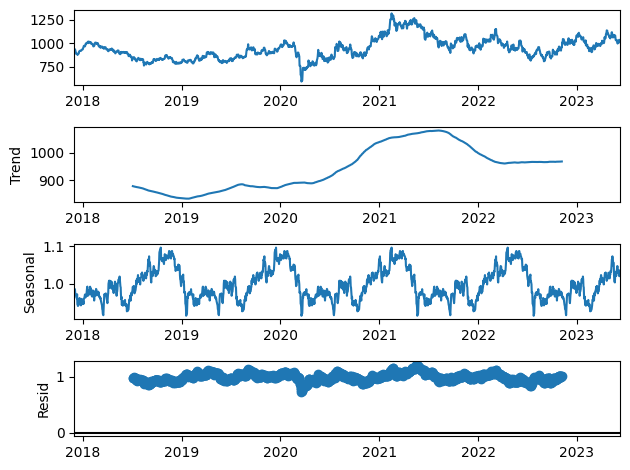

In [ ]:
# Perform seasonal decomposition on the resampled dataframe using a multiplicative model and a period of  (day)
decompose = df
decompose_result = seasonal_decompose(decompose,model='mul', period=365)
decompose_result.plot();

# Split dataset (7-2-1)

---



In [ ]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_value = test.Price.values
  pred_value = pred.values
  test_ape = np.abs((test_value - pred_value) / test_value)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val.tail(len(val)))
  print('MAE: ', val_mae)

  val_value = val.Price.values
  pred_val_value = pred_val.tail(len(val)).values
  val_ape = np.abs((val_value - pred_val_value) / val_value)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val.tail(len(val)))
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [ ]:
# Spilit data (7-2-1)
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

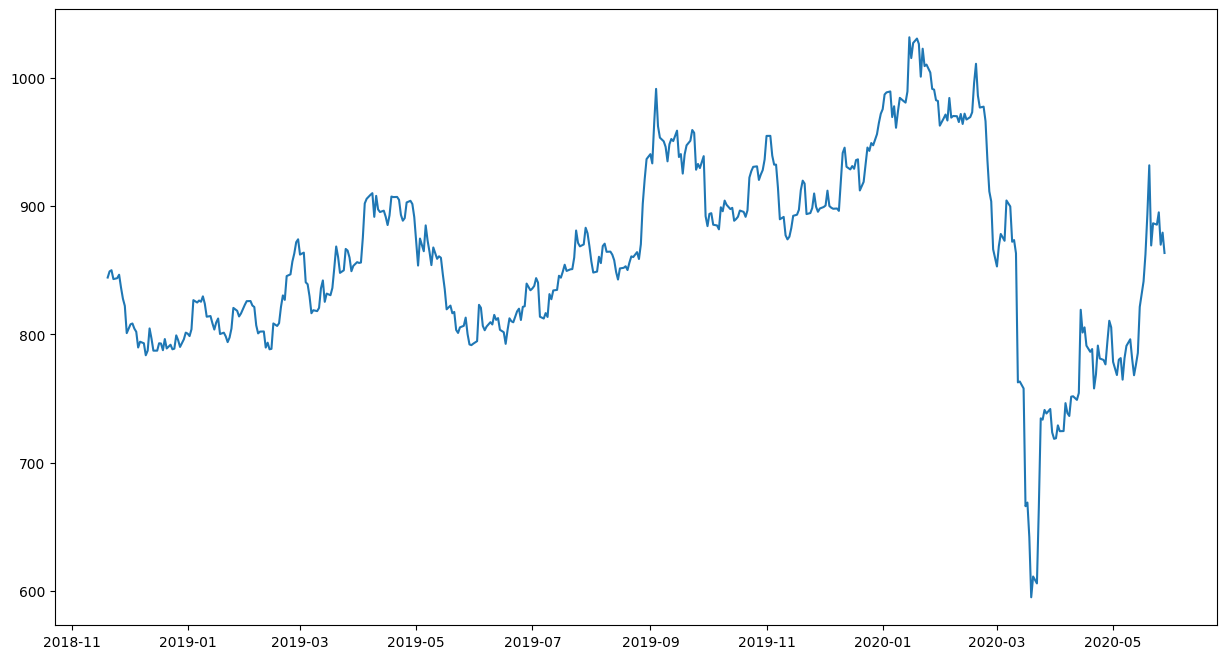

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[300:777], train['Price'][300:777]);

In [ ]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=460, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df) + len(val))
pred_val = fit.forecast(len(val) + len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


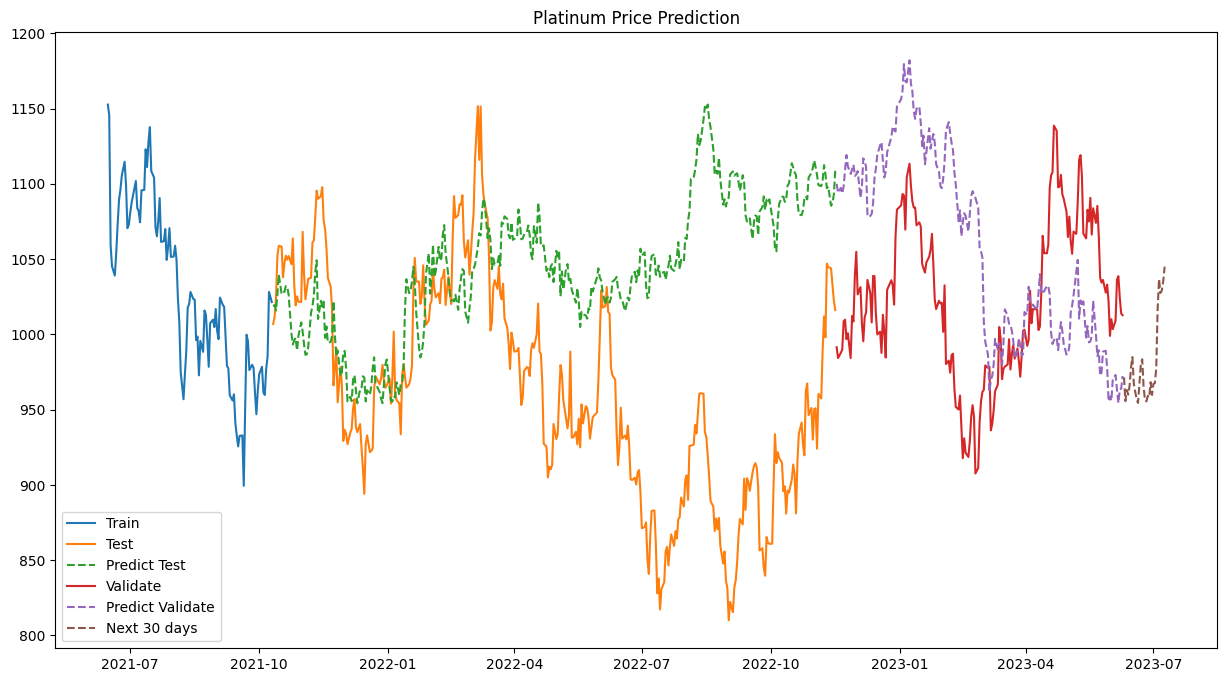

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['Price'][train_size - 100:], label="Train");
# ax.plot(train.index, train['Price'], label="Train");
ax.plot(test.index, test['Price'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(val.index, val, label="Validate")
ax.plot(val.index, pred_val.tail(len(val)), linestyle='--', label="Predict Validate")
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("Platinum Price Prediction");

In [ ]:
evaluateModel(test, pred, val, pred_val)

** Testing **
MAE:  98.03697291861579
MAPE:  10.714014541050137
RMSE:  123.90266028414283

** Validate **
MAE:  75.20475965723888
MAPE:  7.407463392684598
RMSE:  86.62888072222253


In [ ]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                 1202
Model:             ExponentialSmoothing   SSE                         205166.921
Optimized:                         True   AIC                           7108.084
Trend:                   Multiplicative   BIC                           9475.744
Seasonal:                Multiplicative   AICC                          7703.605
Seasonal Periods:                   460   Date:                 Mon, 19 Jun 2023
Box-Cox:                          False   Time:                         13:08:24
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.8889240                alpha                 True
smoothing_trend       

# Split dataset (6-3-1)

---

In [ ]:
# Spilit data (6-3-1)
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

In [ ]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=394, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df) + len(val))
pred_val = fit.forecast(len(val) + len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


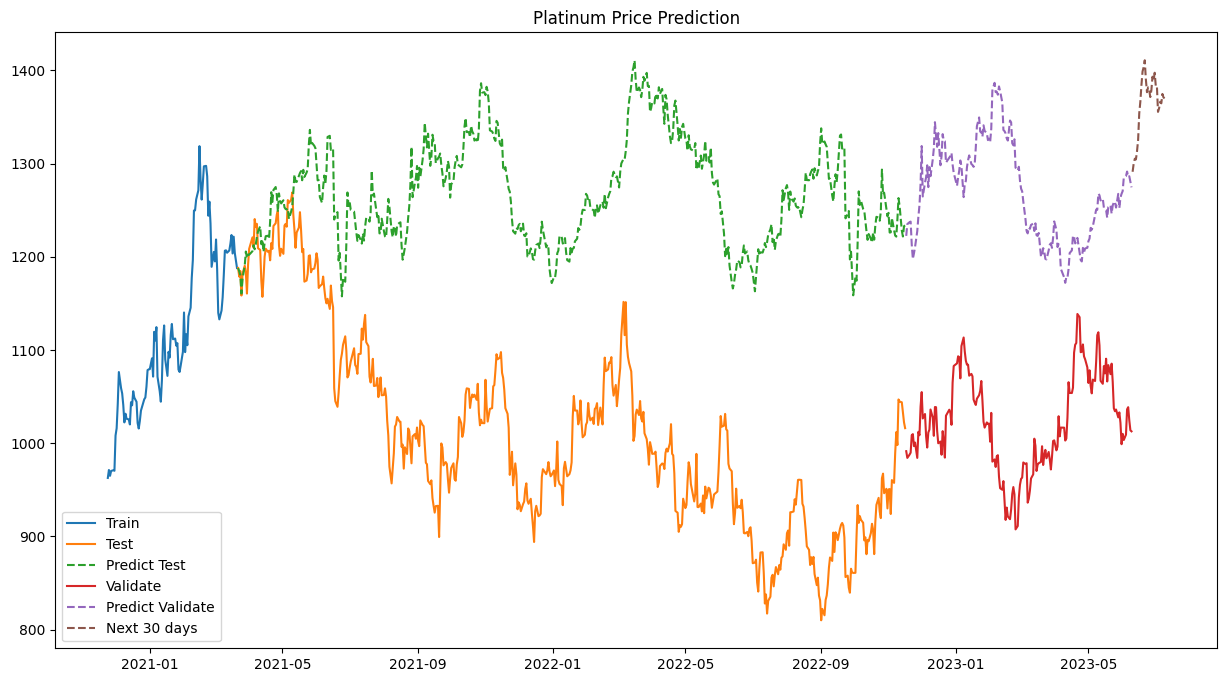

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['Price'][train_size - 100:], label="Train");
# ax.plot(train.index, train['Price'], label="Train");
ax.plot(test.index, test['Price'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(val.index, val, label="Validate")
ax.plot(val.index, pred_val.tail(len(val)), linestyle='--', label="Predict Validate")
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("Platinum Price Prediction");

In [ ]:
evaluateModel(test, pred, val, pred_val)

** Testing **
MAE:  258.85691513017844
MAPE:  26.912576289219352
RMSE:  282.64520338582673

** Validate **
MAE:  246.8536563704319
MAPE:  24.50024453977089
RMSE:  259.28180413460035


In [ ]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                 1030
Model:             ExponentialSmoothing   SSE                         167149.353
Optimized:                         True   AIC                           6040.009
Trend:                   Multiplicative   BIC                           8009.997
Seasonal:                Multiplicative   AICC                          6553.391
Seasonal Periods:                   394   Date:                 Mon, 19 Jun 2023
Box-Cox:                          False   Time:                         13:08:31
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.8889273                alpha                 True
smoothing_trend       

# Split Dataset (5-3-2)

---



In [ ]:
# Spilit data (5-3-2)
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

In [ ]:
# Holt's Winter (Recommended, as the gold price should have trend and seasonal)
holt_winter = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=333, damped_trend=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Fit Holt's Winter and get prediction
fit = holt_winter.fit(optimized=True)
pred = fit.forecast(len(test))

# Get prediction for 30 days
pred_30_days = fit.forecast(len(test) + len(forecast_df) + len(val))
pred_val = fit.forecast(len(val) + len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


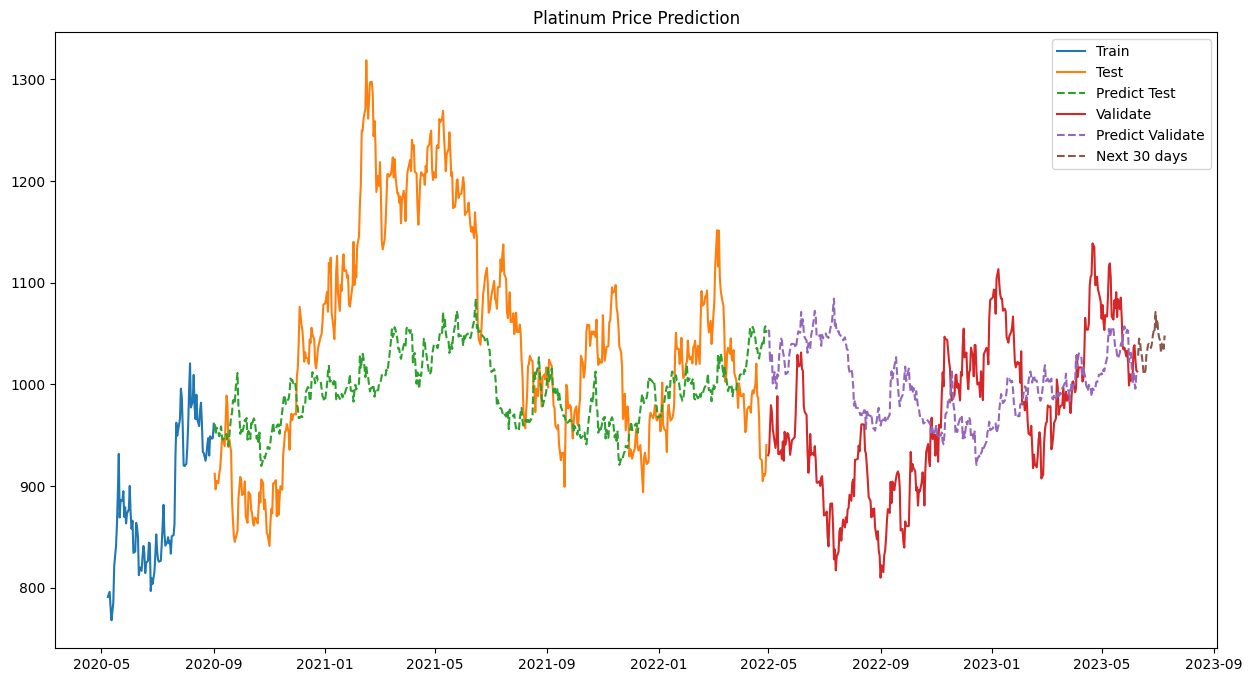

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train.index[train_size - 100:], train['Price'][train_size - 100:], label="Train");
# ax.plot(train.index, train['Price'], label="Train");
ax.plot(test.index, test['Price'], label='Test');
ax.plot(test.index, pred, linestyle='--', label="Predict Test");
ax.plot(val.index, val, label="Validate")
ax.plot(val.index, pred_val.tail(len(val)), linestyle='--', label="Predict Validate")
ax.plot(forecast_df.index, pred_30_days.tail(30), linestyle='--', label="Next 30 days")
ax.legend();
ax.set_title("Platinum Price Prediction");

In [ ]:
evaluateModel(test, pred, val, pred_val)

** Testing **
MAE:  83.5140060594758
MAPE:  7.648498155032299
RMSE:  104.53357523499479

** Validate **
MAE:  74.20738377005917
MAPE:  7.920719060277633
RMSE:  90.39768261487801


In [ ]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Price   No. Observations:                  859
Model:             ExponentialSmoothing   SSE                         109343.736
Optimized:                         True   AIC                           4839.129
Trend:                   Multiplicative   BIC                           6446.579
Seasonal:                Multiplicative   AICC                          5286.774
Seasonal Periods:                   333   Date:                 Mon, 19 Jun 2023
Box-Cox:                          False   Time:                         13:08:41
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9596378                alpha                 True
smoothing_trend       

# Evaluating Model

---

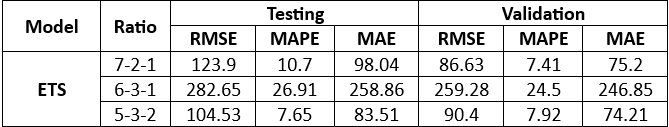